### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

### Loading and cleaning the data

In [ ]:
df1 = pd.read_csv('./data/voc_2010-2022.csv')
df2 = pd.read_csv('./data/HYY_META.T336_1997-01-01--9999-09-09.csv')

In [ ]:
# remove from df1 other columns than monoterpene_flux
# remove from df2 Unnamed
df1 = df1.drop(columns=['Unnamed: 0', 'methanol_flux', 'acetone_flux', 'acetaldehyde_flux'])
df2 = df2.drop(columns=['Unnamed: 0'])

In [ ]:
# Convert time labels to datetime objects
df1['Datetime'] = pd.to_datetime(df1['Datetime'])
df2['Datetime'] = pd.to_datetime(df2['Datetime'])

In [ ]:
# keep only observations occurring during 11.00-14.00 each day
df1 = df1[(df1['Datetime'].dt.hour>=11) & (df1['Datetime'].dt.hour<=14)]
df2 = df2[(df2['Datetime'].dt.hour>=11) & (df2['Datetime'].dt.hour<=14)]

In [ ]:
# Keep only the measurements after start_time
# Monoterpene data should be available
START_TIME = pd.to_datetime('2010-06-01')
df1 = df1[df1['Datetime'] >= START_TIME]
df2 = df2[df2['Datetime'] >= START_TIME]

In [ ]:
# use daily median from measurements between 11-14
daily_df1 = df1.resample('D', on = 'Datetime').median().reset_index()
daily_df2 = df2.resample('D', on = 'Datetime').median().reset_index()

In [ ]:
# combine with temperature data, use only years when monoterpene data available (already done above)
df_combined = pd.merge(daily_df1, daily_df2, on='Datetime', how='outer')

In [ ]:
# drop lines where there is missing data
df_combined = df_combined.dropna()

### Step 1

The air-temperature data used here is T336 since I didn't find the 16.8m height data

In [ ]:
# calculate the EF(t)
df_combined["EF_t"] = (df_combined["monoterpene_flux"] * np.exp(0.09*(25-df_combined["HYY_META.T336"]))) 

### Step 2

In [ ]:
# Calculate the E(t) for air-temperature data-set
df_combined["E_t"] = df_combined["EF_t"] / np.exp(0.09*(25-df_combined["HYY_META.T336"]))

In [ ]:
# Calculate the difference between the estimate and the observation
df_combined["Difference"] = (df_combined["monoterpene_flux"] - df_combined["E_t"])

In [ ]:
plt.plot(df_combined['Difference'])

The differences are very small, and it seems that there is something wrong in the calculations.

### Monoterpene baseline calculation v2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
# Load the data
MT = pd.read_csv('data/voc_2010-2022.csv') # Monoterpene data
T = pd.read_csv('data/HYY_META.T168_1997-01-01--9999-09-09.csv') # Temperature data

In [3]:
# remove from MT other columns than monoterpene_flux
# remove from T Unnamed
MT = MT.drop(columns=['Unnamed: 0', 'methanol_flux', 'acetone_flux', 'acetaldehyde_flux'])
T = T.drop(columns=['Unnamed: 0'])

In [4]:

# Convert time labels to datetime objects and set an index
MT['Datetime'] = pd.to_datetime(MT['Datetime'])
MT.set_index('Datetime', inplace=True)
T['Datetime'] = pd.to_datetime(T['Datetime'])
T.set_index('Datetime', inplace=True)

In [5]:
# Keep only the measurements after start_time Monoterpene data should be available
START_TIME = pd.to_datetime('2010-06-01')
MT = MT[MT.index >= START_TIME]
T = T[T.index >= START_TIME]

In [6]:
print(MT.head())
print(MT.shape)

                     monoterpene_flux
Datetime                             
2010-06-01 05:22:00          72.18297
2010-06-01 08:22:00          32.48285
2010-06-01 11:22:00          44.32782
2010-06-01 17:22:00         138.54898
2010-06-01 20:22:00          25.00049
(15831, 1)


In [7]:
MT.tail()

,monoterpene_flux
Datetime,
2022-12-30 11:22:00,86.1430
2022-12-30 14:22:00,2.9648
2022-12-30 17:22:00,-7.1231
2022-12-30 20:22:00,-16.9710
2022-12-30 23:22:00,-36.8120


In [8]:
print(T.head())
print(T.shape)

                     HYY_META.T168
Datetime                          
2010-06-01 00:00:00           9.52
2010-06-01 00:01:00           9.53
2010-06-01 00:02:00           9.52
2010-06-01 00:03:00           9.47
2010-06-01 00:04:00           9.46
(6960710, 1)


In [9]:
T.tail()

,HYY_META.T168
Datetime,
2023-12-31 23:55:00,-17.60
2023-12-31 23:56:00,-17.60
2023-12-31 23:57:00,-17.71
2023-12-31 23:58:00,-17.77
2023-12-31 23:59:00,-17.80


Temperature data ends 2023 and monoterpene 2022. 

In [10]:
# Get the last date of the monoterpene data
END_TIME = MT.index[-1].date()

# Get the temperature data for the same period
T = T[T.index.date <= END_TIME]
T.tail()

,HYY_META.T168
Datetime,
2022-12-30 23:55:00,1.65
2022-12-30 23:56:00,1.63
2022-12-30 23:57:00,1.65
2022-12-30 23:58:00,1.63
2022-12-30 23:59:00,1.58


In [11]:
MT.tail()

,monoterpene_flux
Datetime,
2022-12-30 11:22:00,86.1430
2022-12-30 14:22:00,2.9648
2022-12-30 17:22:00,-7.1231
2022-12-30 20:22:00,-16.9710
2022-12-30 23:22:00,-36.8120


#### Step 1

In [12]:
# Filter out years with warm summers (2010, 2018, 2021)
warm_summer_years = [2010, 2018, 2021]
filtered_MT = MT[~MT.index.year.isin(warm_summer_years)]
filtered_T = T[~T.index.year.isin(warm_summer_years)]

In [13]:
print(filtered_MT.shape)
print(filtered_T.shape)

(11741, 1)
(5109854, 1)


In [14]:
filtered_MT

,monoterpene_flux
Datetime,
2011-03-07 20:22:00,NaN
2011-03-08 11:22:00,NaN
2011-03-08 14:22:00,-4.22413
2011-03-08 17:22:00,10.00322
2011-03-08 20:22:00,-16.48562
...,...
2022-12-30 11:22:00,86.14300
2022-12-30 14:22:00,2.96480
2022-12-30 17:22:00,-7.12310


In [15]:
filtered_T

,HYY_META.T168
Datetime,
2011-01-01 00:00:00,-7.15
2011-01-01 00:01:00,-7.12
2011-01-01 00:02:00,-7.14
2011-01-01 00:03:00,-7.10
2011-01-01 00:04:00,-7.10
...,...
2022-12-30 23:55:00,1.65
2022-12-30 23:56:00,1.63
2022-12-30 23:57:00,1.65


In [16]:
# Keep only observations occurring during 11.00 and 14.00 each day
filtered_MT = filtered_MT[(filtered_MT.index.hour == 11) | (filtered_MT.index.hour == 14)]
filtered_T = filtered_T[(filtered_T.index.hour == 11) | (filtered_T.index.hour == 14)]

In [17]:
filtered_MT

,monoterpene_flux
Datetime,
2011-03-08 11:22:00,NaN
2011-03-08 14:22:00,-4.22413
2011-03-09 11:22:00,34.33977
2011-03-09 14:22:00,NaN
2011-03-10 11:22:00,-2.15036
...,...
2022-12-28 14:22:00,-9.48310
2022-12-29 11:22:00,-11.67800
2022-12-29 14:22:00,-2.46000


In [18]:
filtered_T

,HYY_META.T168
Datetime,
2011-01-01 11:00:00,-7.38
2011-01-01 11:01:00,-7.39
2011-01-01 11:02:00,-7.43
2011-01-01 11:03:00,-7.44
2011-01-01 11:04:00,-7.43
...,...
2022-12-30 14:55:00,1.12
2022-12-30 14:56:00,1.11
2022-12-30 14:57:00,1.07


Monoterpene has only one sample in an hour, but temperatures are sampled in every minute

In [19]:
# Group the daily temperature data by hour and calculate the mean of the hour
filtered_T = filtered_T.resample('h').mean()
filtered_T

,HYY_META.T168
Datetime,
2011-01-01 11:00:00,-7.632167
2011-01-01 12:00:00,NaN
2011-01-01 13:00:00,NaN
2011-01-01 14:00:00,-7.787167
2011-01-01 15:00:00,NaN
...,...
2022-12-30 10:00:00,NaN
2022-12-30 11:00:00,0.235000
2022-12-30 12:00:00,NaN


In [20]:
# Drop the NaN values, so we have only the hours 11 and 14
filtered_T = filtered_T.dropna()
filtered_T

,HYY_META.T168
Datetime,
2011-01-01 11:00:00,-7.632167
2011-01-01 14:00:00,-7.787167
2011-01-02 11:00:00,-12.300667
2011-01-02 14:00:00,-11.426333
2011-01-03 11:00:00,-12.527500
...,...
2022-12-28 14:00:00,-1.361667
2022-12-29 11:00:00,-3.435667
2022-12-29 14:00:00,-2.892500


In [21]:
# Set the minutes to 0 in the monoterpene data index to mach the temperature data index
filtered_MT.index = filtered_MT.index.map(lambda x: x.replace(minute=0))
filtered_MT

,monoterpene_flux
Datetime,
2011-03-08 11:00:00,NaN
2011-03-08 14:00:00,-4.22413
2011-03-09 11:00:00,34.33977
2011-03-09 14:00:00,NaN
2011-03-10 11:00:00,-2.15036
...,...
2022-12-28 14:00:00,-9.48310
2022-12-29 11:00:00,-11.67800
2022-12-29 14:00:00,-2.46000


In [22]:
# Join the data sets based on the datetime index
filtered_data = pd.merge(filtered_MT, filtered_T, left_index=True, right_index=True, how='inner')
filtered_data

,monoterpene_flux,HYY_META.T168
Datetime,,
2011-03-08 11:00:00,NaN,-1.846667
2011-03-08 14:00:00,-4.22413,-0.366333
2011-03-09 11:00:00,34.33977,0.682333
2011-03-09 14:00:00,NaN,3.218500
2011-03-10 11:00:00,-2.15036,-0.054167
...,...,...
2022-12-28 14:00:00,-9.48310,-1.361667
2022-12-29 11:00:00,-11.67800,-3.435667
2022-12-29 14:00:00,-2.46000,-2.892500


At the end we want medians from every 4th day or so on. For that we create a data frame to which has the desired dates.

In [23]:
# Create a list to store desired dates
desired_dates = []
SAMPLE_FREQ = '4D'

# Loop through years and months to generate desired dates
for year in range(2011, 2023):
    for month in range(1, 13):
        dates = pd.date_range(start=f'{year}-{month}-01', end=f'{year}-{month}-28', freq=SAMPLE_FREQ)
        desired_dates.extend(dates)

desired_dates_df = pd.DataFrame(index=desired_dates)

In [24]:
desired_dates_df

""
2011-01-01
2011-01-05
2011-01-09
2011-01-13
2011-01-17
...
2022-12-09
2022-12-13
2022-12-17
2022-12-21


In [25]:
# Set a date column for the desired_dates_df and filetered_data to merge them
desired_dates_df['Date'] = desired_dates_df.index.date
filtered_data['Date'] = filtered_data.index.date

In [26]:
# Keep only the observations that are in the desired dates by joining the data sets
filtered_data = pd.merge(desired_dates_df, filtered_data, on='Date', how='inner')
filtered_data

,Date,monoterpene_flux,HYY_META.T168
0,2011-03-09,34.33977,0.682333
1,2011-03-09,NaN,3.218500
2,2011-03-13,NaN,-3.640333
3,2011-03-13,-20.09444,0.061667
4,2011-03-21,23.98960,-0.977167
...,...,...,...
725,2022-11-17,66.33300,-2.418167
726,2022-11-17,-44.34400,-2.238167
727,2022-12-21,-4.73740,0.811000
728,2022-12-25,0.58157,-6.338167


In [27]:
# drop lines where there is missing data
filtered_data = filtered_data.dropna()
filtered_data

,Date,monoterpene_flux,HYY_META.T168
0,2011-03-09,34.33977,0.682333
3,2011-03-13,-20.09444,0.061667
4,2011-03-21,23.98960,-0.977167
5,2011-03-21,-17.01800,0.747167
7,2011-03-25,1.16900,-7.752833
...,...,...,...
725,2022-11-17,66.33300,-2.418167
726,2022-11-17,-44.34400,-2.238167
727,2022-12-21,-4.73740,0.811000
728,2022-12-25,0.58157,-6.338167


In [28]:
# Rename the columns to MT and T
filtered_data.columns = ['Date', 'MT', 'T']

In [29]:
filtered_data

,Date,MT,T
0,2011-03-09,34.33977,0.682333
3,2011-03-13,-20.09444,0.061667
4,2011-03-21,23.98960,-0.977167
5,2011-03-21,-17.01800,0.747167
7,2011-03-25,1.16900,-7.752833
...,...,...,...
725,2022-11-17,66.33300,-2.418167
726,2022-11-17,-44.34400,-2.238167
727,2022-12-21,-4.73740,0.811000
728,2022-12-25,0.58157,-6.338167


#### EF calculation

In [30]:
# function to calculate EF
#def calculate_EF(MT, T):
#    EF = MT * np.exp(0.09 * (25 - T))
#    return EF

def calculate_EF(df: pd.DataFrame) -> pd.DataFrame:
    EF_df = df.copy()
    EF_df['EF'] = EF_df['MT'] * np.exp(0.09 * (25 - EF_df['T']))
    return EF_df

In [31]:
# Calculate EF for each time point
EF = calculate_EF(filtered_data)
EF

,Date,MT,T,EF
0,2011-03-09,34.33977,0.682333,306.400833
3,2011-03-13,-20.09444,0.061667,-189.595558
4,2011-03-21,23.98960,-0.977167,248.530457
5,2011-03-21,-17.01800,0.747167,-150.961767
7,2011-03-25,1.16900,-7.752833,22.284774
...,...,...,...,...
725,2022-11-17,66.33300,-2.418167,782.365882
726,2022-11-17,-44.34400,-2.238167,-514.611585
727,2022-12-21,-4.73740,0.811000,-41.783372
728,2022-12-25,0.58157,-6.338167,9.761158


In [32]:
# Drop the ngeative values EF values as adviced, and also MT and T columns because they are not needed
EF = EF[EF['EF'] >= 0]
EF = EF.drop(columns=['MT', 'T'])
EF

,Date,EF
0,2011-03-09,306.400833
4,2011-03-21,248.530457
7,2011-03-25,22.284774
9,2011-04-09,46.096658
10,2011-04-09,118.842665
...,...,...
723,2022-11-13,715.885971
724,2022-11-13,63.935408
725,2022-11-17,782.365882
728,2022-12-25,9.761158


In [33]:
# Change the date column to datetime object so we can make the necessary groupby
EF['Date'] = pd.to_datetime(EF['Date'])

In [34]:
# Make a month and day of the year (e.g. 01-05) so we can group by them
EF['month_day'] = EF['Date'].dt.strftime('%m-%d')
EF

,Date,EF,month_day
0,2011-03-09,306.400833,03-09
4,2011-03-21,248.530457,03-21
7,2011-03-25,22.284774,03-25
9,2011-04-09,46.096658,04-09
10,2011-04-09,118.842665,04-09
...,...,...,...
723,2022-11-13,715.885971,11-13
724,2022-11-13,63.935408,11-13
725,2022-11-17,782.365882,11-17
728,2022-12-25,9.761158,12-25


We were instrcuted to have 365/4 EF median values, but the actual number depends on how we choose the dates and on February we have only 28 days which sets the upper limit.

In [35]:
# Group by month_day and calculate the median of the EF values
EF_grouped = EF.groupby('month_day').median()
EF_grouped

,Date,EF
month_day,,
01-05,2017-01-05,72.374155
01-13,2017-01-13,62.082417
01-17,2017-01-17,86.806180
01-21,2019-01-21,354.684843
01-25,2019-01-25,7.607782
...,...,...
12-09,2020-12-09,184.557321
12-13,2020-12-13,255.107881
12-17,2013-12-17,153.010212


In [36]:
# Add a day of the year (1-365) column to the EF_grouped data for plotting
EF_grouped['day_of_year'] = EF_grouped['Date'].dt.dayofyear
EF_grouped


,Date,EF,day_of_year
month_day,,,
01-05,2017-01-05,72.374155,5
01-13,2017-01-13,62.082417,13
01-17,2017-01-17,86.806180,17
01-21,2019-01-21,354.684843,21
01-25,2019-01-25,7.607782,25
...,...,...,...
12-09,2020-12-09,184.557321,344
12-13,2020-12-13,255.107881,348
12-17,2013-12-17,153.010212,351


#### Interpolation

In [37]:
# Function to interpolate the EF values
def interpolate_EF(EF: pd.DataFrame, kind='linear') -> np.ndarray:
    f = interp1d(np.arange(0, len(EF)), EF, kind=kind) # kind='cubic' or 'linear'
    xnew = np.linspace(0, len(EF) - 1, 365)
    EF_interpolated = f(xnew)
    return EF_interpolated


In [38]:
interpolated = interpolate_EF(EF_grouped['EF'], kind='linear')
interpolated

array([  72.37415497,   70.08396044,   67.79376591,   65.50357138,
         63.21337685,   64.86723605,   70.36895254,   75.87066904,
         81.37238553,   87.54210999,  147.152472  ,  206.76283401,
        266.37319601,  325.98355802,  314.63749018,  237.4033089 ,
        160.16912762,   82.93494634,   11.75964083,  179.90992796,
        348.0602151 ,  516.21050224,  684.36078937,  701.44514501,
        585.02937514,  468.61360526,  352.19783539,  239.10989258,
        212.54545343,  185.98101429,  159.41657514,  132.85213599,
        133.42445945,  156.81633327,  180.20820709,  203.60008091,
        225.0705047 ,  209.55301539,  194.03552609,  178.51803678,
        163.00054748,  158.04870898,  161.54939111,  165.05007325,
        168.55075539,  171.49061298,  165.90593752,  160.32126207,
        154.73658661,  149.15191116,  144.50775524,  140.579212  ,
        136.65066877,  132.72212554,  154.5295296 ,  498.03627476,
        841.54301993, 1185.04976509, 1528.55651025, 1493.85315

In [39]:
# Check the length of the interpolated EF values
len(interpolated)

365

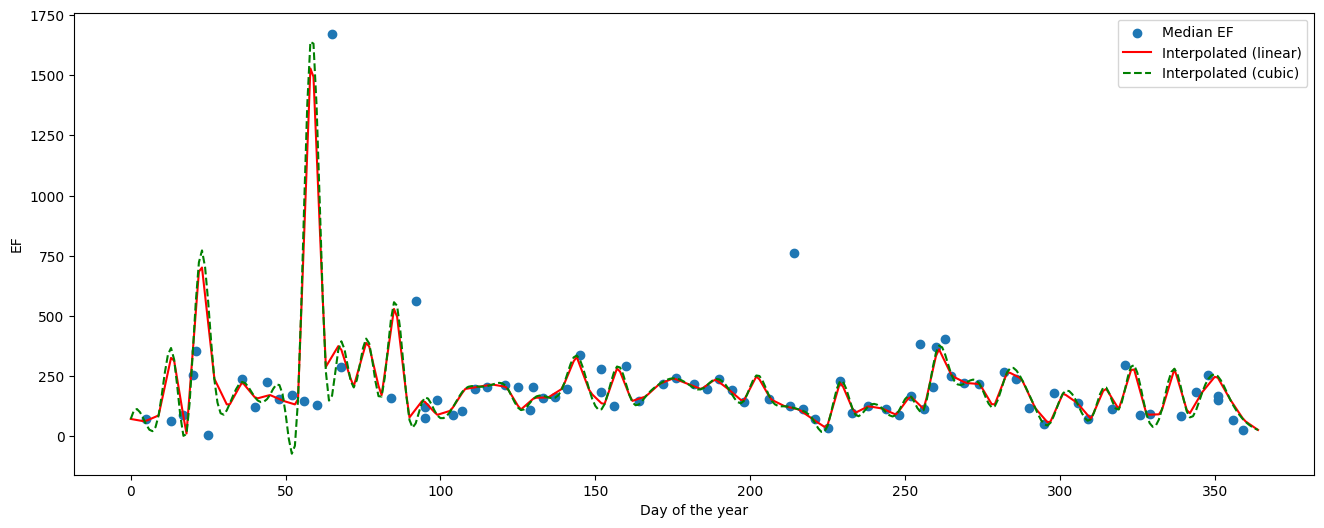

In [40]:
# Plot the interpolated EF values as a line whith linear and cubic interpolation using the function above
plt.figure(figsize=(16, 6))
plt.scatter(EF_grouped['day_of_year'], EF_grouped['EF'], label='Median EF')
plt.plot(np.arange(0, 365), interpolate_EF(EF_grouped['EF'], kind='linear'), label='Interpolated (linear)', linestyle='-', color='red')
plt.plot(np.arange(0, 365), interpolate_EF(EF_grouped['EF'], kind='cubic'), label='Interpolated (cubic)', linestyle='--', color='green')
plt.xlabel('Day of the year')
plt.ylabel('EF')
plt.legend()
plt.show()



### Step 2

In [41]:
filtered_T

,HYY_META.T168
Datetime,
2011-01-01 11:00:00,-7.632167
2011-01-01 14:00:00,-7.787167
2011-01-02 11:00:00,-12.300667
2011-01-02 14:00:00,-11.426333
2011-01-03 11:00:00,-12.527500
...,...
2022-12-28 14:00:00,-1.361667
2022-12-29 11:00:00,-3.435667
2022-12-29 14:00:00,-2.892500


In [42]:
# Make a day of the year (1-365) column to the filtered_T data for calculating the theoretical monoterpene flux
filtered_T['day_of_year'] = filtered_T.index.dayofyear
filtered_T

/tmp/ipykernel_97009/1446394192.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_T.loc[:, 'day_of_year'] = filtered_T.index.dayofyear


,HYY_META.T168,day_of_year
Datetime,,
2011-01-01 11:00:00,-7.632167,1
2011-01-01 14:00:00,-7.787167,1
2011-01-02 11:00:00,-12.300667,2
2011-01-02 14:00:00,-11.426333,2
2011-01-03 11:00:00,-12.527500,3
...,...,...
2022-12-28 14:00:00,-1.361667,362
2022-12-29 11:00:00,-3.435667,363
2022-12-29 14:00:00,-2.892500,363


In [43]:
# Create a mapping between day_of_year and interplated coefficients
coefficients_mapping = dict(zip(range(1, 366), interpolated))

In [44]:
coefficients_mapping

{1: 72.37415496663259,
 2: 70.08396043708782,
 3: 67.79376590754305,
 4: 65.50357137799828,
 5: 63.213376848453514,
 6: 64.86723604692473,
 7: 70.36895254102127,
 8: 75.87066903511783,
 9: 81.37238552921438,
 10: 87.54210999261173,
 11: 147.15247200007178,
 12: 206.7628340075317,
 13: 266.3731960149917,
 14: 325.9835580224518,
 15: 314.6374901780233,
 16: 237.40330889969806,
 17: 160.16912762137278,
 18: 82.9349463430475,
 19: 11.759640828055936,
 20: 179.9099279647471,
 21: 348.0602151014383,
 22: 516.2105022381287,
 23: 684.3607893748199,
 24: 701.4451450120932,
 25: 585.0293751382519,
 26: 468.61360526441064,
 27: 352.19783539056937,
 28: 239.10989258069011,
 29: 212.5454534338253,
 30: 185.98101428696035,
 31: 159.4165751400954,
 32: 132.8521359932305,
 33: 133.42445944630805,
 34: 156.81633326751927,
 35: 180.2082070887305,
 36: 203.60008090994174,
 37: 225.07050470021534,
 38: 209.55301539493948,
 39: 194.03552608966362,
 40: 178.51803678438776,
 41: 163.0005474791119,
 42: 158.0

In [45]:
filtered_T['coeff'] = filtered_T['day_of_year'].map(coefficients_mapping)
filtered_T

/tmp/ipykernel_97009/2350956377.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_T['coeff'] = filtered_T['day_of_year'].map(coefficients_mapping)


,HYY_META.T168,day_of_year,coeff
Datetime,,,
2011-01-01 11:00:00,-7.632167,1,72.374155
2011-01-01 14:00:00,-7.787167,1,72.374155
2011-01-02 11:00:00,-12.300667,2,70.083960
2011-01-02 14:00:00,-11.426333,2,70.083960
2011-01-03 11:00:00,-12.527500,3,67.793766
...,...,...,...
2022-12-28 14:00:00,-1.361667,362,53.060620
2022-12-29 11:00:00,-3.435667,363,44.232018
2022-12-29 14:00:00,-2.892500,363,44.232018


#### E calculation

In [46]:
filtered_T['E'] = filtered_T['coeff'] / np.exp(0.09 * (25 - filtered_T['HYY_META.T168']))
filtered_T

/tmp/ipykernel_97009/1114465333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_T['E'] = filtered_T['coeff'] / np.exp(0.09 * (25 - filtered_T['HYY_META.T168']))


,HYY_META.T168,day_of_year,coeff,E
Datetime,,,,
2011-01-01 11:00:00,-7.632167,1,72.374155,3.838011
2011-01-01 14:00:00,-7.787167,1,72.374155,3.784842
2011-01-02 11:00:00,-12.300667,2,70.083960,2.441552
2011-01-02 14:00:00,-11.426333,2,70.083960,2.641439
2011-01-03 11:00:00,-12.527500,3,67.793766,2.314041
...,...,...,...,...
2022-12-28 14:00:00,-1.361667,362,53.060620,4.947513
2022-12-29 11:00:00,-3.435667,363,44.232018,3.422047
2022-12-29 14:00:00,-2.892500,363,44.232018,3.593490


In [47]:
# Merge the filtered_MT and filtered_T data sets to get the difference between the estimate and the observation
theoretical_MT = pd.merge(filtered_MT, filtered_T, left_index=True, right_index=True, how='inner')
theoretical_MT

,monoterpene_flux,HYY_META.T168,day_of_year,coeff,E
Datetime,,,,,
2011-03-08 11:00:00,NaN,-1.846667,67,353.319927,31.537394
2011-03-08 14:00:00,-4.22413,-0.366333,67,353.319927,36.031875
2011-03-09 11:00:00,34.33977,0.682333,68,374.714293,41.995978
2011-03-09 14:00:00,NaN,3.218500,68,374.714293,52.763985
2011-03-10 11:00:00,-2.15036,-0.054167,69,359.680663,37.725701
...,...,...,...,...,...
2022-12-28 14:00:00,-9.48310,-1.361667,362,53.060620,4.947513
2022-12-29 11:00:00,-11.67800,-3.435667,363,44.232018,3.422047
2022-12-29 14:00:00,-2.46000,-2.892500,363,44.232018,3.593490


In [48]:
# Drop the columns that are not needed
theoretical_MT = theoretical_MT.drop(columns=['HYY_META.T168', 'day_of_year', 'coeff'])
theoretical_MT

,monoterpene_flux,E
Datetime,,
2011-03-08 11:00:00,NaN,31.537394
2011-03-08 14:00:00,-4.22413,36.031875
2011-03-09 11:00:00,34.33977,41.995978
2011-03-09 14:00:00,NaN,52.763985
2011-03-10 11:00:00,-2.15036,37.725701
...,...,...
2022-12-28 14:00:00,-9.48310,4.947513
2022-12-29 11:00:00,-11.67800,3.422047
2022-12-29 14:00:00,-2.46000,3.593490


In [50]:
theoretical_MT.describe()

,monoterpene_flux,E
count,2932.000000,3209.000000
mean,47.022026,54.151425
std,90.575816,49.103391
min,-451.520000,0.549863
25%,3.234495,20.662269
50%,27.657080,39.160201
75%,69.988897,70.441169
max,1880.000000,391.292241


In [51]:
# Get all monoterpene flux values which are negative
negative_MT = theoretical_MT[theoretical_MT['monoterpene_flux'] < 0]
negative_MT

,monoterpene_flux,E
Datetime,,
2011-03-08 14:00:00,-4.22413,36.031875
2011-03-10 11:00:00,-2.15036,37.725701
2011-03-10 14:00:00,-1.89731,42.832047
2011-03-11 14:00:00,-9.35496,33.720263
2011-03-12 14:00:00,-8.53581,28.415689
...,...,...
2022-12-26 14:00:00,-40.79700,4.383915
2022-12-28 11:00:00,-13.32500,4.753494
2022-12-28 14:00:00,-9.48310,4.947513


In [52]:
theoretical_MT[theoretical_MT['E'] < 0]

,monoterpene_flux,E
Datetime,,


### NEE baseline

In [3]:
baseline_NEE = pd.read_csv('data/hyytiala_modelfluxes_2010-2019.csv')

In [5]:
baseline_NEE.columns

Index(['time', 'photosynthesis', 'respiration_canopy', 'respiration_trunk',
       'respiration_soil', 'relative_humidity', 'soil_moisture', 'air_temp',
       'soil_temp', 'irradiation', 'weather', 'co2', 'sample_day'],
      dtype='object')

Theretical NEE is calculated by: respiration_canopy + respiration_trunk + respiration_soil - photosynthesis

In [6]:
# Drop the columns that are not needed
baseline_NEE = baseline_NEE.drop(columns=['relative_humidity', 'soil_moisture', 'air_temp','soil_temp', 'irradiation', 'weather', 'co2', 'sample_day'])
baseline_NEE

,time,photosynthesis,respiration_canopy,respiration_trunk,respiration_soil
0,2010-01-01 00:00:00,0.0,0.000000,0.000000,0.609066
1,2010-01-01 00:30:00,0.0,0.000000,0.000000,0.606867
2,2010-01-01 01:00:00,0.0,0.000000,0.000000,0.606867
3,2010-01-01 01:30:00,0.0,0.000000,0.000000,0.606867
4,2010-01-01 02:00:00,0.0,0.000000,0.000000,0.605403
...,...,...,...,...,...
169570,2019-12-31 21:30:00,0.0,0.097098,0.032366,0.812693
169571,2019-12-31 22:00:00,0.0,0.106984,0.035661,0.812202
169572,2019-12-31 22:30:00,0.0,0.108134,0.036045,0.812202
169573,2019-12-31 23:00:00,0.0,0.108088,0.036029,0.812202


In [8]:
# Drop the rows that have zero values in the photosynthesis, respiration_canopy,	respiration_trunk and respiration_soil
baseline_NEE = baseline_NEE[(baseline_NEE['photosynthesis'] != 0) & 
                            (baseline_NEE['respiration_canopy'] != 0) & 
                            (baseline_NEE['respiration_trunk'] != 0) & 
                            (baseline_NEE['respiration_soil'] != 0)]
baseline_NEE

,time,photosynthesis,respiration_canopy,respiration_trunk,respiration_soil
493,2010-01-11 23:30:00,8.200501e-07,0.022790,0.007597,0.600709
495,2010-01-12 00:30:00,4.891754e-07,0.024962,0.008321,0.600813
496,2010-01-12 01:00:00,6.849029e-07,0.027653,0.009218,0.600918
498,2010-01-12 02:00:00,3.593141e-06,0.030007,0.010002,0.601647
500,2010-01-12 03:00:00,1.025807e-05,0.033268,0.011089,0.602063
...,...,...,...,...,...
169554,2019-12-31 13:30:00,4.086046e-01,0.168642,0.056214,0.804012
169555,2019-12-31 14:00:00,2.702518e-01,0.164384,0.054795,0.803402
169556,2019-12-31 14:30:00,1.312732e-01,0.144745,0.048248,0.804378
169557,2019-12-31 15:00:00,3.444579e-02,0.122583,0.040861,0.806208


In [12]:
# Calculate the theoretical NEE
baseline_NEE.loc[:, 'NEE_theoretical'] = (
    baseline_NEE['respiration_canopy'] + 
    baseline_NEE['respiration_trunk'] + 
    baseline_NEE['respiration_soil'] - 
    baseline_NEE['photosynthesis']
)

baseline_NEE

,time,photosynthesis,respiration_canopy,respiration_trunk,respiration_soil,NEE_theoretical
493,2010-01-11 23:30:00,8.200501e-07,0.022790,0.007597,0.600709,0.631095
495,2010-01-12 00:30:00,4.891754e-07,0.024962,0.008321,0.600813,0.634096
496,2010-01-12 01:00:00,6.849029e-07,0.027653,0.009218,0.600918,0.637787
498,2010-01-12 02:00:00,3.593141e-06,0.030007,0.010002,0.601647,0.641652
500,2010-01-12 03:00:00,1.025807e-05,0.033268,0.011089,0.602063,0.646411
...,...,...,...,...,...,...
169554,2019-12-31 13:30:00,4.086046e-01,0.168642,0.056214,0.804012,0.620263
169555,2019-12-31 14:00:00,2.702518e-01,0.164384,0.054795,0.803402,0.752329
169556,2019-12-31 14:30:00,1.312732e-01,0.144745,0.048248,0.804378,0.866097
169557,2019-12-31 15:00:00,3.444579e-02,0.122583,0.040861,0.806208,0.935206


### Combination of theoretical and measurement NEE datasets

In [13]:
# load the observed NEE data
observed_NEE = pd.read_csv('data/GPP_NEE_flux_2001-2022.csv')

In [14]:
observed_NEE

,Unnamed: 0,Datetime,NEE,NEE_gapfilling_method,GPP
0,0,2001-01-01 00:00:00,0.459,1,-0.000
1,1,2001-01-01 00:30:00,0.459,1,-0.000
2,2,2001-01-01 01:00:00,0.459,1,-0.000
3,3,2001-01-01 01:30:00,0.459,1,-0.000
4,4,2001-01-01 02:00:00,0.458,1,-0.000
...,...,...,...,...,...
385675,385675,2022-12-31 21:30:00,2.100,0,-1.002
385676,385676,2022-12-31 22:00:00,2.588,0,-1.491
385677,385677,2022-12-31 22:30:00,2.134,0,-1.043
385678,385678,2022-12-31 23:00:00,1.260,0,-0.181


In [15]:
# Drop the Unnamed:0, NEE_gapfillling_methdo and GPP columns
observed_NEE = observed_NEE.drop(columns=['Unnamed: 0', 'NEE_gapfilling_method', 'GPP'])
# Convert the Datetime column to datetime object and set it as index
observed_NEE['Datetime'] = pd.to_datetime(observed_NEE['Datetime'])
observed_NEE.set_index('Datetime', inplace=True)
observed_NEE

,NEE
Datetime,
2001-01-01 00:00:00,0.459
2001-01-01 00:30:00,0.459
2001-01-01 01:00:00,0.459
2001-01-01 01:30:00,0.459
2001-01-01 02:00:00,0.458
...,...
2022-12-31 21:30:00,2.100
2022-12-31 22:00:00,2.588
2022-12-31 22:30:00,2.134


In [16]:
# Drop the photosynthesis, respiration_canopy, respiration_trunk and respiration_soil columns from the baseline_NEE data
baseline_NEE = baseline_NEE.drop(columns=['photosynthesis', 'respiration_canopy', 'respiration_trunk', 'respiration_soil'])
# Set the time column to datetime object and set it as index
baseline_NEE['time'] = pd.to_datetime(baseline_NEE['time'])
baseline_NEE.set_index('time', inplace=True)

In [17]:
baseline_NEE

,NEE_theoretical
time,
2010-01-11 23:30:00,0.631095
2010-01-12 00:30:00,0.634096
2010-01-12 01:00:00,0.637787
2010-01-12 02:00:00,0.641652
2010-01-12 03:00:00,0.646411
...,...
2019-12-31 13:30:00,0.620263
2019-12-31 14:00:00,0.752329
2019-12-31 14:30:00,0.866097


In [18]:
# Observed NEE data and baseline NEE data have different time ranges
# We need to filter the observed NEE data to match the time range of the baseline NEE data
observed_NEE = observed_NEE[(observed_NEE.index >= baseline_NEE.index[0]) & (observed_NEE.index <= baseline_NEE.index[-1])]
observed_NEE

,NEE
Datetime,
2010-01-11 23:30:00,0.506
2010-01-12 00:00:00,0.496
2010-01-12 00:30:00,0.496
2010-01-12 01:00:00,0.497
2010-01-12 01:30:00,0.498
...,...
2019-12-31 13:30:00,0.729
2019-12-31 14:00:00,0.751
2019-12-31 14:30:00,2.024


In [19]:
# Merge the observed NEE data and the baseline NEE data
# If there are missing values in each data set, fill them with NaN
combined_NEE = pd.merge(baseline_NEE, observed_NEE, left_index=True, right_index=True, how='outer')
combined_NEE

,NEE_theoretical,NEE
2010-01-11 23:30:00,0.631095,0.506
2010-01-12 00:00:00,NaN,0.496
2010-01-12 00:30:00,0.634096,0.496
2010-01-12 01:00:00,0.637787,0.497
2010-01-12 01:30:00,NaN,0.498
...,...,...
2019-12-31 13:30:00,0.620263,0.729
2019-12-31 14:00:00,0.752329,0.751
2019-12-31 14:30:00,0.866097,2.024
2019-12-31 15:00:00,0.935206,1.628


In [20]:
combined_NEE.describe()

,NEE_theoretical,NEE
count,107889.000000,174753.000000
mean,-2.327767,-0.682491
std,5.494001,4.582278
min,-19.047672,-24.984000
25%,-6.170656,-1.393000
50%,0.169801,0.509000
75%,1.338686,1.515000
max,8.531268,14.828000
